In [1]:
#Initial imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_roc_curve, precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingRegressor, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

# Set pandas to display all columns, since our data has many columns and we'd like to see them all
pd.set_option('display.max_columns', None)

In [2]:
def display_metrics(fit_model, Xtr, Xte, ytr, yte):
    '''
    This function takes in a model that's already been fit, then X and y train and test data.
    It uses the fitted model to get predicted values for the train and test data,
    and then uses sklearn's score functions to print out the accuracy, recall, precision,  f1, and roc-auc scores.
    It then plots a confusion matrix of the test data.
    '''
    train_preds = fit_model.predict(Xtr)
    test_preds = fit_model.predict(Xte)
    train_probs = fit_model.predict_proba(Xtr)[:,1]
    test_probs = fit_model.predict_proba(Xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fit_model, Xte, yte)
    plot_roc_curve(fit_model, Xte, yte)

In [3]:
# Read in dataframe
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

In [4]:
# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q24_R', 'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'K8Q21', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later
bool_cols = [*no_cols, *yes_cols]
use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

In [5]:
# Map boolean columns to boolean
bool_mask = {
    1: 1,
    2: 0,
    3: 0
}
for col in bool_cols:
    df[col] = df[col].map(bool_mask)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

In [6]:
# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

In [7]:
# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [10]:
start_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                   max_depth=3, min_samples_leaf=1, min_samples_split=2))
])

start_tree.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('no_pre',
                                                  Pipeline(steps=[('no_imp',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['SC_SEX', 'K4Q32X01',
                                                   'K4Q32X02', 'K4Q32X03',
                                                   'K4Q32X04', 'K4Q32X05',
                                                   'DENTALSERV1', 'DENTALSERV2',
                                                   'DENTALSERV3', 'DENTALSERV4',
                                                   'DENTALSERV5', 'DENTALSERV6',
                                                   'DENTALSERV7', 'K4Q28X01',
                                                   'K4Q28X02', 'K4Q28X03',
               


Train Accuracy:		0.8970523812503911
Test Accuracy:		0.8909227447667324

Train Recall:		0.8969505783385909
Test Recall:		0.8548895899053628

Train Precision:	0.21087762669962917
Test Precision:		0.19538572458543618

Train f1:		0.3414731785428342
Test f1:		0.318075117370892

Train ROC-AUC:		0.940932794355279
Test ROC-AUC:		0.9274820296705765


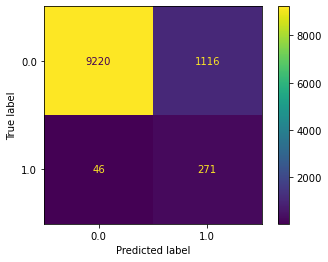

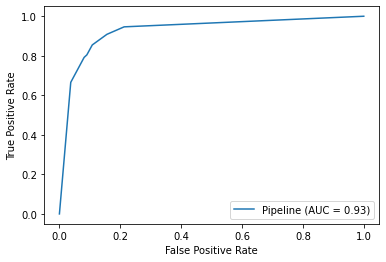

In [11]:
display_metrics(start_tree, X_train, X_test, y_train, y_test)

In [13]:
# Read in dataframe
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

In [14]:
# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q36', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q24_R', 'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'K8Q21', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later
bool_cols = [*no_cols, *yes_cols]
use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

In [15]:
# Map boolean columns to boolean
bool_mask = {
    1: 1,
    2: 0,
    3: 0
}
for col in bool_cols:
    df[col] = df[col].map(bool_mask)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

In [16]:
# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

In [17]:
# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Moved K4Q36 from no_cols to drop_cols as a test

In [18]:
# Read in dataframe
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE', 'K4Q36'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36A', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q24_R', 'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'SC_CSHCN', 'K4Q30_R', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'K8Q21', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later
bool_cols = [*no_cols, *yes_cols]
use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

# Map boolean columns to boolean
bool_mask = {
    1: 1,
    2: 0,
    3: 0
}
for col in bool_cols:
    df[col] = df[col].map(bool_mask)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [20]:
# test_tree = Pipeline(steps=[
#     ('preproc', full_preprocessor),
#     ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))
# ])

# param_grid = {
#     'tree__criterion': ['gini', 'entropy'],
#     'tree__max_depth': [None, 1,2,3,4,5,10,20],
#     'tree__min_samples_leaf': [1,2,3,4,5,10,20],
#     'tree__min_samples_split': [1,2,3,4,5,10,20]
# }

# grid_search = GridSearchCV(estimator=test_tree, param_grid=param_grid,
#                              n_jobs=-1, 
#                              verbose=1,
#                              return_train_score=True,
#                              scoring='recall',
#                              cv=StratifiedKFold(n_splits=5))

# grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 784 candidates, totalling 3920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 3920 out of 3920 | elapsed: 19.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            


Train Accuracy:		0.7747042993929533
Test Accuracy:		0.772082981319816

Train Recall:		0.9369085173501577
Test Recall:		0.9526813880126183

Train Precision:	0.11094508778483377
Test Precision:		0.11123388581952118

Train f1:		0.19839679358717435
Test f1:		0.19920844327176782

Train ROC-AUC:		0.9124173039587378
Test ROC-AUC:		0.9215176077487279


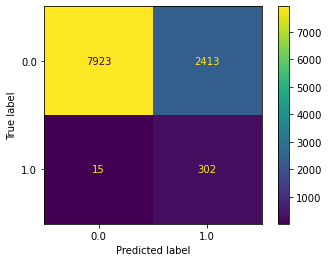

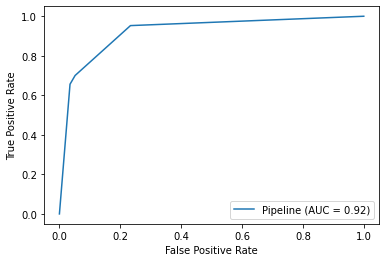

In [21]:
display_metrics(grid_search.best_estimator_, X_train, X_test, y_train, y_test)

In [22]:
grid_search.best_params_

{'tree__criterion': 'gini',
 'tree__max_depth': 2,
 'tree__min_samples_leaf': 1,
 'tree__min_samples_split': 2}


Train Accuracy:		0.7747042993929533
Test Accuracy:		0.772082981319816

Train Recall:		0.9369085173501577
Test Recall:		0.9526813880126183

Train Precision:	0.11094508778483377
Test Precision:		0.11123388581952118

Train f1:		0.19839679358717435
Test f1:		0.19920844327176782

Train ROC-AUC:		0.9124173039587378
Test ROC-AUC:		0.9215176077487279


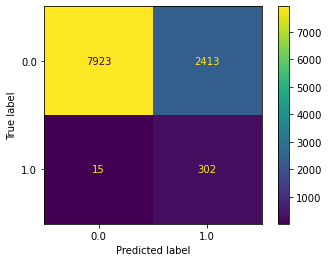

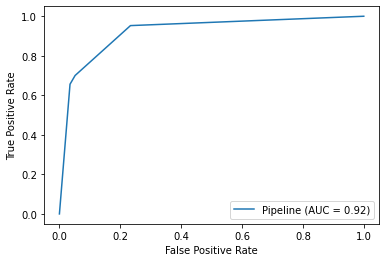

In [23]:
new_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42,
                                   max_depth=2, min_samples_leaf=1, min_samples_split=2))
])

new_tree.fit(X_train, y_train)
display_metrics(new_tree, X_train, X_test, y_train, y_test)

In [28]:
feature_importance = dict(zip(use_cols, new_tree.named_steps['tree'].feature_importances_))

In [29]:
for key, val in feature_importance.items():
    if val > 0:
        print(F'{key}: {val}')

K2Q36A: 0.17834564969109307
SC_CSHCN: 0.8216543503089069


Gonna try dropping these two features and see what we get

In [33]:
# Read in dataframe
df = pd.read_sas('../../data/nsch_2020_topical.sas7bdat')

# Map target column to boolean and rename to target
mask = {
    1.0: 1.0,
    2.0: 0.0
}
df['Target'] = df['K2Q35A'].map(mask)

# Drop rows where target is null
df.dropna(subset=['Target'], inplace=True)

# Define which columns to drop
drop_cols = [
    'A1_ACTIVE', 'A1_AGE', 'A1_BORN', 'A1_DEPLSTAT', 'A1_EMPLOYED', 'A1_GRADE', 'A1_LIVEUSA', 'A1_MARITAL',
    'A1_MENTHEALTH', 'A1_PHYSHEALTH', 'A1_RELATION', 'A1_SEX', 'A2_ACTIVE', 'A2_AGE', 'A2_BORN', 'A2_DEPLSTAT', 
    'A2_EMPLOYED', 'A2_GRADE', 'A2_LIVEUSA', 'A2_MARITAL', 'A2_MENTHEALTH', 'A2_PHYSHEALTH', 'A2_RELATION', 'A2_SEX', 
    'ALLERGIES_DESC', 'ARTHRITIS_DESC', 'ASKQUESTION', 'ASKQUESTION2', 'AUTISMMED', 'AUTISMTREAT', 'BESTFORCHILD', 
    'BLOOD_DESC', 'BMICLASS', 'BREASTFEDEND_DAY_S', 'BREASTFEDEND_MO_S', 'BREASTFEDEND_WK_S', 'CALMDOWN', 'CERPALS_DESC',
    'CLEAREXP', 'COLOR', 'CONFIDENT', 'COUNTTO', 'DIRECTIONS', 'DIRECTIONS2', 'DISCUSSOPT', 'DISTRACTED', 'DOCPRIVATE',
    'FAMCOUNT', 'FIPSST', 'FORMTYPE', 'FRSTFORMULA_DAY_S', 'FRSTFORMULA_MO_S','FRSTFORMULA_WK_S', 'FRSTSOLIDS_DAY_S', 
    'FRSTSOLIDS_MO_S', 'FRSTSOLIDS_WK_S', 'GENETIC_DESC', 'HCEXTENT', 'HEADACHE_DESC', 'HEART_DESC', 'HHCOUNT',
    'HHCOUNT_IF', 'HHID', 'HOURSLEEP', 'HOURSLEEP05', 'HURTSAD', 'K12Q01_A', 'K12Q01_B', 'K12Q01_C', 'K12Q01_D', 
    'K12Q01_E', 'K12Q01_F', 'K12Q01_G', 'K2Q30C', 'K2Q31C', 'K2Q32C', 'K2Q33C', 'K2Q34C', 'K2Q35A', 'K2Q35A_1_YEARS', 
    'K2Q35B', 'K2Q35C', 'K2Q35D', 'K2Q36C', 'K2Q37C', 'K2Q38C', 'K2Q40C', 'K2Q41C', 'K2Q42C', 'K2Q60C', 'K4Q26',
    'K4Q28X_EAR','K4Q37', 'K5Q11','K5Q21', 'K5Q22', 'K5Q32','K6Q08_R','K6Q10','K6Q12','K6Q13A','K6Q13B','K6Q14A','K6Q14B',
    'K6Q20','K6Q27', 'K6Q40', 'K6Q41R_STILL','K6Q42R_NEVER','K6Q43R_NEVER','K6Q60_R','K6Q61_R','K6Q70_R','K6Q72_R',
    'K6Q73_R','K9Q41', 'KEEPINSADULT','LIVEUSA_MO','LIVEUSA_YR','LIVEUSA_YR', 'K6Q42R_NEVER','MEDHISTORY','NEWACTIVITY',
    'ONEWORD','PLANNEEDS_R','PLAYWELL','POINT','RAISECONC','RECEIVECOPY','RECOGABC','RECOGBEGIN','RECSHAPES','RHYMEWORD',
    'SC_K2Q11','SC_K2Q12','SC_K2Q14','SC_K2Q15','SC_K2Q17','SC_K2Q18','SC_K2Q20','SC_K2Q21','SC_K2Q23','SC_RACEAIAN',
    'SC_RACEASIA','SESPLANMO','SESPLANYR','SIMPLEINST','SITSTILL','SLEEPPOS', 'SPCSERVMO','STARTSCHOOL','STRATUM',
    'TELLSTORY','TEMPER','THREEWORDS','TREATADULT', 'TREATNEED', 'TWOWORDS','UNDERSTAND', 'UNDERSTAND2', 'USEPENCIL', 
    'WORKTOFIN', 'WRITENAME', 'HEALTHKNOW', 'K8Q35', 'EMOSUPSPO', 'EMOSUPFAM', 'EMOSUPHCP', 'EMOSUPWOR', 'EMOSUPADV', 
    'EMOSUPPEER', 'EMOSUPMHP', 'EMOSUPOTH', 'K3Q20', 'K3Q22', 'K3Q21B', 'K7Q02R_R', 'DOCROOM', 'K4Q02_R', 'DENTISTVISIT', 
    'FWC', 'A1_GRADE_IF', 'FPL_IF', 'HIGRADE_TVIS', 'HIGRADE', 'INSTYPE', 'INSGAP', 'CURRINS', 'HOUSE_GEN', 'SC_SEX_IF', 
    'SC_HISPANIC_R_IF', 'SC_RACE_R_IF', 'TOTFEMALE', 'TOTMALE', 'AGEPOS4', 'SC_AGE_LT10', 'SC_AGE_LT9', 'SC_AGE_LT6', 
    'SC_AGE_LT4', 'TOTNONSHCN', 'TOTCSHCN', 'TOTAGE_12_17', 'TOTAGE_6_11', 'TOTAGE_0_5', 'MPC_YN', 'YEAR', 'K3Q04_R', 
    'TENURE', 'K4Q36', 'SC_CSHCN', 'K2Q36A'
]

# Define which cols to impute with no
no_cols = [
    'SC_SEX', 'K4Q32X01', 'K4Q32X02', 'K4Q32X03', 'K4Q32X04', 'K4Q32X05', 'DENTALSERV1', 'DENTALSERV2', 'DENTALSERV3',
    'DENTALSERV4', 'DENTALSERV5', 'DENTALSERV6', 'DENTALSERV7', 'K4Q28X01', 'K4Q28X02', 'K4Q28X03', 'K4Q28X04', 'K4Q28X05',
    'BREATHING', 'SWALLOWING', 'STOMACH', 'PHYSICALPAIN', 'HANDS', 'COORDINATION', 'TOOTHACHES', 'GUMBLEED', 'CAVITIES',
    'MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'ERRANDALONE', 'K2Q43B', 'BLINDNESS', 'ALLERGIES', 'ALLERGIES_CURR',
    'ARTHRITIS', 'ARTHRITIS_CURR', 'K2Q40A', 'K2Q40B', 'K2Q61A', 'K2Q61B', 'K2Q41A', 'K2Q41B', 'K2Q42A', 'K2Q42B', 'HEART',
    'HEART_BORN', 'HEART_CURR', 'HEADACHE', 'HEADACHE_CURR', 'K2Q38A', 'K2Q38B', 'K2Q33A', 'K2Q33B', 'K2Q32A', 'K2Q32B',
    'DOWNSYN', 'BLOOD', 'SICKLECELL', 'THALASSEMIA', 'BLOOD_OTHER', 'BLOOD_SCREEN', 'CYSTFIB', 'CYSTFIB_SCREEN', 'GENETIC',
    'GENETIC_SCREEN', 'K2Q34A', 'K2Q34B', 'K2Q36B', 'K2Q60A', 'K2Q60B', 'K2Q37A', 'K2Q37B', 'K2Q30A', 'K2Q30B',
    'K2Q31A', 'K2Q31B', 'K2Q31D', 'ADDTREAT', 'CONCUSSION', 'SEEKCARE', 'CONFIRMINJURY', 'K2Q05', 'OVERWEIGHT', 'K4Q01',
    'USUALGO', 'USUALSICK', 'K4Q31_R', 'K4Q23', 'ALTHEALTH', 'K4Q27', 'NOTELIG', 'AVAILABLE', 'APPOINTMENT', 'TRANSPORTCC',
    'NOTOPEN', 'ISSUECOST', 'HOSPITALSTAY', 'SESCURRSVC', 'K4Q38', 'K5Q10', 'DECISIONS', 'K12Q03', 'K12Q04',
    'K12Q12', 'TRICARE', 'K11Q03R', 'HCCOVOTH', 'K3Q25', 'REPEATED', 'K7Q30', 'K7Q31', 'K7Q32', 'K7Q37', 'K7Q38', 'ACE3',
    'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'ACE12', 'ACE1', 'K7Q04R_R', 'WGTCONC', 'K4Q22_R', 'K4Q24_R',
    'K4Q24_R', 'K4Q04_R', 'K5Q31_R',  'BIRTHWT', 'BIRTHWT_L', 'BIRTHWT_VL', 'SC_K2Q22', 'SC_K2Q19', 'SC_K2Q16', 'SC_K2Q13',
    'SC_K2Q10', 'K4Q30_R', 'K4Q30_R'
]

# Define which cols to impute with yes
yes_cols = [
    'S4Q01', 'CURRCOV', 'BORNUSA'
]

# Define which cols to impute with mode
mode_cols = [
    'HHLANGUAGE', 'K9Q40', 'K11Q60', 'K11Q61', 'K11Q62', 'S9Q34', 'K10Q11', 'K10Q12', 'K10Q13', 'K10Q14', 'K10Q20',
    'K10Q22', 'K10Q23', 'K9Q96', 'BULLIED_R', 'BULLY', 'TOTKIDS_R', 'SC_AGE_YEARS', 'BIRTH_MO', 'BIRTH_YR', 'SC_RACER', 
    'SC_RACE_R'
]

# Define which cols to impute with median
med_cols = [
    'MOMAGE', 'K11Q43R', 'K2Q01', 'K2Q01_D', 'K6Q71_R', 'TALKABOUT', 'WKTOSOLVE', 'STRENGTHS', 'HOPEFUL', 'K10Q30',
    'K10Q31', 'K10Q40_R', 'GOFORHELP', 'K10Q41_R', 'HOWMUCH', 'K8Q31', 'K8Q32', 'K8Q34', 'ATHOMEHC', 'ARRANGEHC',
    'SCREENTIME', 'K8Q11', 'HCABILITY', 'K8Q30', 'K8Q21', 'FAMILY_R', 'BIRTHWT_OZ_S', 'SC_ENGLISH', 'MAKEFRIEND',
    'BEDTIME', 'K7Q33'
]

# Define which cols to impute with median and add null flag
med_flag_cols = [
    'K5Q40', 'K5Q41', 'K5Q42', 'K5Q43', 'K5Q44', 'FOODSIT', 'MENBEVCOV'
]

# Define which cols to impute with constant 5
five_cols = [
    'K7Q84_R', 'K7Q85_R', 'K7Q82_R', 'K7Q83_R', 'K7Q70_R', 'K8Q21'
]

# Define lists to be used later
bool_cols = [*no_cols, *yes_cols]
use_cols = [*no_cols, *yes_cols, *mode_cols, *med_cols, *med_flag_cols, *five_cols]

# Adds remaining columns with many nulls to drop cols
for col in df.columns:
    if col not in use_cols and col not in drop_cols:
        if (df[col].isna().sum() / len(df)) > .5:
            drop_cols.append(col)

# Map boolean columns to boolean
bool_mask = {
    1: 1,
    2: 0,
    3: 0
}
for col in bool_cols:
    df[col] = df[col].map(bool_mask)

# Define imputers to make up preprocessor
no_imp = Pipeline(steps=[
    ('no_imp', SimpleImputer(strategy='constant', fill_value=0))
])
yes_imp = Pipeline(steps=[
    ('yes_imp', SimpleImputer(strategy='constant', fill_value=1))
])
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent'))
])
med_imp = Pipeline(steps=[
    ('med_imp', SimpleImputer(strategy='median'))
])
med_flag_imp = Pipeline(steps=[
    ('med_flag_imp', SimpleImputer(strategy='median', add_indicator=True))
])
five_imp = Pipeline(steps=[
    ('five_imp', SimpleImputer(strategy='constant', fill_value=5))
])

# Create full preprocessor
full_preprocessor = ColumnTransformer(transformers=[
    ('no_pre', no_imp, no_cols),
    ('yes_pre', yes_imp, yes_cols),
    ('mode_pre', mode_imp, mode_cols),
    ('med_cols', med_imp, med_cols),
    ('med_flag_cols', med_flag_imp, med_flag_cols),
    ('five_cols', five_imp, five_cols)
])

# Drop the dropcols
df = df.drop(columns=[*drop_cols])

# Split to x and y
y = df['Target']
X = df.drop(columns=['Target'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [34]:
newer_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

test_tree = Pipeline(steps=[
    ('preproc', full_preprocessor),
    ('tree', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [None, 1,2,3,4,5,10],
    'tree__min_samples_leaf': [1,2,3,4,5,10],
    'tree__min_samples_split': [1,2,3,4,5,10]
}

grid_search = GridSearchCV(estimator=test_tree, param_grid=param_grid,
                             n_jobs=-1, 
                             verbose=1,
                             return_train_score=True,
                             scoring='recall',
                             cv=StratifiedKFold(n_splits=5))

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 10.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('no_pre',
                                                                         Pipeline(steps=[('no_imp',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['SC_SEX',
                                                                          'K4Q32X01',
                                                                          'K4Q32X02',
                                                                          'K4Q32X03',
                                                                          'K4Q32X04',
            


Train Accuracy:		0.8406971650291007
Test Accuracy:		0.8412653712569229

Train Recall:		0.889589905362776
Test Recall:		0.8738170347003155

Train Precision:	0.14506172839506173
Test Precision:		0.14367219917012447

Train f1:		0.24944714727996464
Test f1:		0.24677060133630288

Train ROC-AUC:		0.8971706026016242
Test ROC-AUC:		0.8879764517877548


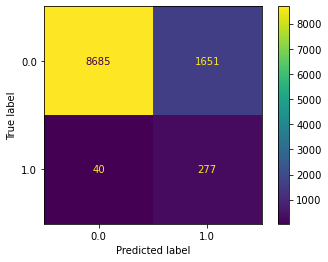

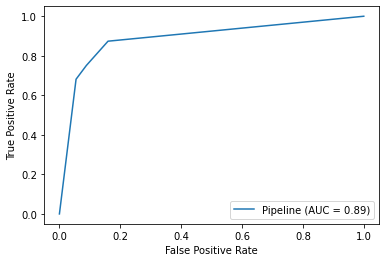

In [35]:
display_metrics(grid_search.best_estimator_, X_train, X_test, y_train, y_test)

In [36]:
feature_importance = dict(zip(use_cols, new_tree.named_steps['tree'].feature_importances_))

In [37]:
for key, val in feature_importance.items():
    if val > 0:
        print(F'{key}: {val}')

K2Q36B: 0.17834564969109307
K4Q30_R: 0.8216543503089069
